In [1]:
import pandas as pd
from datetime import datetime
from math import log

import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
pylab.rcParams['figure.figsize'] = 20, 10
%matplotlib inline

import seaborn as sns
sns.set(style="whitegrid", color_codes=True)

### 1. Read data
The data set includes information on 1675 ICOs. The data is a snapshot on 3 Feb 2018, the day the data is extracted from ICOBench, instead of a time-series data.

Here are the features we will focus on in this blog post. 

- categories - the business category of the coin, a coin can be classified under multiple categories.
- country - country of the ICO.
- exchanges - exchanges the coin is listed on and the return on investment (ROI) of the coin in that particular exchange. A coin can be listed on multiple exchanges hence have multiple ROI values. Note that the ROI is the total period return between the end date of the ICO and 3 Feb 2018, the day the data was extracted from ICObench.
- dates - contain key dates of the ICO, such as its start and end date.
- rating - a combination of ICObench's rating algorithm and ratings given by independent "Experts". ICObench users can apply to be an ICObench Expert and ICObench will review and approve the application according to its own criteria.
- ratingProfile - ratings given by ICObench's rating algorithm
- ratingProduct - ratings given by Experts on the product offered by the ICO
- ratingTeam - ratings given by Experts on the ICO team
- ratingVision - ratings given by Experts on vision of the ICO company

In [2]:
df = pd.read_json('data/icobench_ico_profile_jsonarray.json')
print("Our dataset contains %d ICO data." % (df['id'].count()))

Our dataset contains 1675 ICO data.


In [3]:
df.head()

,_id,about,categories,country,dates,exchanges,finance,id,intro,links,...,ratingProfile,ratingTeam,ratingVision,ratings,registration,restrictions,tagline,team,teamIntro,url
0,{'$oid': '5a72d64ecdb0be4760d44a2e'},<strong>VIBERATE TOKEN CROWDSALE</strong>\r\nV...,"[{'id': 9, 'name': 'Entertainment'}]",Slovenia,"{'preIcoStart': '0000-00-00 00:00:00', 'preIco...","[{'id': 4, 'name': 'HitBTC', 'logo': 'https://...","{'token': 'VIB', 'price': '1 VIB = 0.1 USD', '...",73,Viberate is a crowdsourced live music ecosyste...,{'twitter': 'https://twitter.com/viberate_com'...,...,4.8,4.2,4.0,"[{'date': '2017-08-29', 'name': 'Chris Alexov'...",unknown,[],Token for the live music industry,"[{'name': 'Charlie Shrem', 'title': 'Blockchai...",,https://icobench.com/ico/viberate
1,{'$oid': '5a72e3afcdb0be4760d44eb0'},<strong>Changing the Face of Crowdfunding</str...,"[{'id': 17, 'name': 'Platform'}, {'id': 7, 'na...",Gibraltar,"{'preIcoStart': '0000-00-00 00:00:00', 'preIco...",[],"{'token': 'OAK', 'price': '1 OAK = 1.4 USD', '...",1692,We're helping fulfil crowdfunding's promise of...,{'twitter': 'https://twitter.com/AcoCollective...,...,5.0,4.5,4.1,"[{'date': '2018-01-27', 'name': 'Tarek Roustom...",kyc and whitelist,"[{'country': 'USA'}, {'country': 'China'}]",Let's make crowdfunding free,"[{'name': 'Moritz Kurtz', 'title': 'CO-FOUNDER...",,https://icobench.com/ico/acorn-collective
2,{'$oid': '5a72e3afcdb0be4760d44eb2'},NapoleonX is the first 100% algorithmic crypto...,"[{'id': 17, 'name': 'Platform'}]",France,"{'preIcoStart': '0000-00-00 00:00:00', 'preIco...",[],"{'token': 'NPX', 'price': '1 ETH = 1,000 NPX',...",54,NaPoleonX is the first 100% algorithmic crypto...,"{'twitter': 'https://twitter.com/NapoleonXai',...",...,5.0,4.0,3.6,"[{'date': '2017-11-12', 'name': 'Joao Reis', '...",unknown,[],The first 100% algorithmic crypto asset manager,"[{'name': 'JÃ©rome de Tychey', 'title': '', 'l...",,https://icobench.com/ico/napoleon-x
3,{'$oid': '5a72e779cdb0be4760d459a3'},True Flip is a blockchain lottery platform. We...,"[{'id': 6, 'name': 'Casino & Gambling'}]",Costa Rica,"{'preIcoStart': '0000-00-00 00:00:00', 'preIco...","[{'id': 22, 'name': 'EtherDelta', 'logo': 'htt...","{'token': 'TFL', 'price': '1 TFL = 0.0005 BTC'...",1,The Token Sale will last for 30 days (or until...,{'twitter': 'https://twitter.com/TrueFlipLoto'...,...,4.1,2.8,2.8,"[{'date': '2017-11-11', 'name': 'Joao Reis', '...",unknown,[],Wordwide Blockchain Lottery,"[{'name': 'Eric Benz', 'title': 'Advisor / CEO...",<p>TrueFlip advisors and management team cosis...,https://icobench.com/ico/true-flip
4,{'$oid': '5a72e779cdb0be4760d459a5'},SunContract's business model joins together th...,"[{'id': 2, 'name': 'Energy'}, {'id': 17, 'name...",Slovenia,"{'preIcoStart': '0000-00-00 00:00:00', 'preIco...","[{'id': 4, 'name': 'HitBTC', 'logo': 'https://...","{'token': 'SNC', 'price': '10,000 SNC = 1 ETH'...",2,SunContract is an energy trading platform that...,{'twitter': 'https://twitter.com/sun_contract'...,...,4.5,3.1,2.6,"[{'date': '2017-08-29', 'name': 'Chris Alexov'...",unknown,[],Decentralized energy market platform,"[{'name': 'Jonathan Galea', 'title': 'Blockcha...",,https://icobench.com/ico/suncontract


As you can see, some of the features we are interested in, namely categories, dates and exchanges, are in dictionaries / lists of dictionaries. Let's extract these features one-by-one.

### 2. Extract Categories
Here's an example of the format of the 'categories' feature:

In [5]:
df.loc[1]['categories']

[{'id': 17, 'name': 'Platform'},
 {'id': 7, 'name': 'Business services'},
 {'id': 19, 'name': 'Investment'}]

Since there are a lot of different categories and some only have very few ICOs under them, let's consolidate the top 10 categories with the most ICOs according to ICObench and the rest will be classified as "Others".

In [6]:
# Obtain a list of top 10 categories
cat_list = ['Platform', 'Cryptocurrency', 'Business services', 'Investment', 'Software', 'Entertainment', 
            'Internet', 'Banking', 'Infrastructure', 'Communication']


In [7]:
# extract categories as a list
def get_categories(column):
    if len(column) > 0:
        coin_categories = []
        for item in column:
            if item['name'] in cat_list:
                coin_categories.append(item['name'])
            else:
                coin_categories.append('Others')
    return coin_categories

In [8]:
df['coin_categories'] = df['categories'].apply(get_categories)

In [9]:
# categories are extracted as a list
df['coin_categories'].head()

0                              [Entertainment]
1    [Platform, Business services, Investment]
2                                   [Platform]
3                                     [Others]
4                           [Others, Platform]
Name: coin_categories, dtype: object

In [10]:
# add new category name "Others"
cat_list.append('Others')

In [11]:
# Convert coin_categories to dummy variables for mathematical analysis
def dummy_categories(column, category):
    for i in column['coin_categories']: 
        if len(column['coin_categories']) > 0:
            category_dummy = 0
            if category in column['coin_categories']:
                    category_dummy = 1
    return category_dummy

In [12]:
for cat in cat_list:
    df[cat] = df.apply(lambda x: dummy_categories(x, cat), axis = 1)

Now we have extracted the ICO categories and converted them into dummy variables using one-hot encoding.

In [13]:
df.iloc[0:3, 27:39]

,Platform,Cryptocurrency,Business services,Investment,Software,Entertainment,Internet,Banking,Infrastructure,Communication,Others
0,0,0,0,0,0,1,0,0,0,0,0
1,1,0,1,1,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0


### 3. Extract Countries
First, let's look at the unique values under "country".

In [14]:
df['country'].unique()

array(['Slovenia', 'Gibraltar', 'France', 'Costa Rica', 'South Africa',
       'USA', 'China', 'Netherlands', 'Canada', 'UK', 'Switzerland',
       'Singapore', 'Cayman Islands', 'Belgium', 'Malta', 'Poland',
       'Russia', 'Panama', 'Israel', 'Italy', 'Latvia', 'Japan',
       'Germany', 'Bulgaria', '', 'Hong Kong', 'Estonia', 'Argentina',
       'Marshall Islands', 'United Arab Emirates', 'Belize', 'Georgia',
       'Brazil', 'Ukraine', 'Taiwan', 'India', 'Sweden', 'Malaysia',
       'Seychelles', 'Australia', 'Austria', 'Lithuania', 'Finland',
       'Nigeria', 'Kyrgyzstan', 'Spain', 'Philippines', 'Virgin Islands',
       'Cyprus', 'Isle of Man', 'Kazakhstan', 'Czech Republic', 'Romania',
       'Chile', 'Armenia', 'Thailand', 'Luxembourg', 'Turkey',
       'South Korea', 'Cambodia', 'Belarus', 'Serbia',
       'British Virgin Islands', 'Moldova', 'Monaco', 'Mexico',
       'Colombia', 'Greece', 'Denmark', 'Indonesia', 'Dominican Republic',
       'Ireland', 'Slovakia', 'Kenya', 

It appears that different names are used for the same country, for example -
1. USA, UNITED STATE and United States
2. Slovenia and Slovenija
3. UK, United Kingdom and London
4. Netherlands and The Netherlands
5. Switzerland and Switzerland, (an extra comma in the end)
6. Singapore and SIngapore

Besides, note that there's a unique value "UK, Poland". This will be converted to "Worldwide", one of the existing values under this feature. There are also some null values for "country".

In [15]:
df = df.replace(to_replace={'country': {'UNITED STATE': 'USA', 'United States': 'USA', 'Slovenija': 'Slovenia',
                                       'United Kingdom': 'UK', 'London': 'UK', 'The Netherlands': 'Netherlands', 
                                        'Switzerland,': 'Switzerland', 'SIngapore': 'Singapore', 'UK, Poland': 'Worldwide'}})



Since there are lots of diffferent countries, let's also consolidate them by only extracting the countries with the most ICOs and classifying the rest as "Other Countries".

In [16]:
country_count = df.groupby('country').count()[['id']]

country_count.sort_values(by = ['id'], ascending = False).head(15)


,id
country,
USA,290
Russia,214
,154
UK,137
Singapore,100
Switzerland,65
Estonia,54
Hong Kong,40
Canada,37


In [17]:
# extract the countries with >100 ICOs
major_country = ['USA', 'Russia', 'UK', 'Singapore']

In [18]:
# claffisy the rest as "Other Countries"
def group_countries(column):
    if len(column) > 0:
        if column not in major_country:
            country_group = 'Other Countries'
        else:
            country_group = column
    else:
        country_group = "N/A"
    return country_group

In [19]:
df['country'] = df['country'].apply(group_countries)

### 3. Calculate Average ROI & Annualized Average ROI
As some of the coins are listed on multiple exchanges, an average ROI is calculated for each coin. Besdies, since the period of the ROI is different for each coins (different icoEnd date, hence different duration between icoEnd date and the data extraction date), the ROI will be annualized for fair comparison.

* Note that the following functions were written by my team member at the Unhackathon. I've only done a few textual amendments to them.

In [20]:
# calculate the average ROI
def calc_roi_avg(column):
    if len(column) > 0:
        roi_total = 0
        for item in column: 
            if item['roi']:
                roi_total = roi_total + float(item['roi'].strip('%').replace(",", "")) / 100
        roi_avg = roi_total / len(column)
        return roi_avg

In [21]:
# annualize the average ROI
def calc_ret_anul(column):
    end_date = datetime.strptime('2018-02-03 00:00:00', '%Y-%m-%d %H:%M:%S')
    if 'icoEnd' in column['dates']:
        try:
            # convert to datetime format
            ico_end_date = datetime.strptime(column['dates']['icoEnd'], '%Y-%m-%d %H:%M:%S')
            date_diff_days = (end_date - ico_end_date).days            
            if date_diff_days > 0:            
                return_anul = pow((1 + float(column['roi_avg'])), 365/date_diff_days) - 1
            else:
                # no return if the ICO hasn't ended yet (ico_end_date > end_date)
                return_anul = None
        except:
            return_anul = None
    return return_anul

In [22]:
df['roi_avg'] = df['exchanges'].apply(calc_roi_avg)
df['roi_avg_annu'] = df.apply(calc_ret_anul, axis=1) 

In [1]:
hi = [1,2,3]
def test():
    for i in hi:
        print(i)

In [2]:
test()

1
2
3


### 4. Exploratory Data Analysis
After we have extracted the features, we can now explore the data to learn more about ICOs! Let's see if it gives us insights on investing in profitable ICOs!

In [23]:
# extract annualized average ROI, country, ratings and categories
df2 = df[['id', 'name','roi_avg_annu','country', 'rating', 'ratingProduct', 'ratingProfile', 'ratingTeam', 'ratingVision',
          'Platform', 'Cryptocurrency', 'Business services', 'Investment', 'Software', 'Entertainment','Internet',
          'Banking', 'Infrastructure', 'Communication', 'Others']]

In [24]:
df2.describe(include = 'all')

,id,name,roi_avg_annu,country,rating,ratingProduct,ratingProfile,ratingTeam,ratingVision,Platform,Cryptocurrency,Business services,Investment,Software,Entertainment,Internet,Banking,Infrastructure,Communication,Others
count,1675.000000,1675,3.440000e+02,1675,1675.000000,1675.000000,1675.000000,1675.000000,1675.000000,1675.000000,1675.000000,1675.000000,1675.000000,1675.000000,1675.000000,1675.000000,1675.000000,1675.000000,1675.000000,1675.000000
unique,NaN,1671,NaN,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,Hero,NaN,Other Countries,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,3,NaN,780,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,885.047761,NaN,6.042306e+21,NaN,3.066209,1.796060,3.199821,1.936657,1.965313,0.508060,0.349851,0.236418,0.167164,0.128955,0.109851,0.091940,0.085373,0.068657,0.058507,0.358806
std,519.703534,NaN,1.120681e+23,NaN,0.902210,1.701323,1.067392,1.814269,1.827942,0.500084,0.477065,0.425009,0.373234,0.335250,0.312797,0.289028,0.279520,0.252945,0.234771,0.479793
min,1.000000,NaN,-1.000000e+00,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,433.500000,NaN,0.000000e+00,NaN,2.400000,0.000000,2.400000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,879.000000,NaN,0.000000e+00,NaN,3.300000,2.000000,3.300000,2.000000,2.200000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1335.500000,NaN,3.084609e+00,NaN,3.800000,3.300000,4.100000,3.700000,3.700000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000


Observations:
1. There are lots of missing values for annualized average ROI (roi_avg_annu). After further examining the data, I found that the values are missing due to the following reasons:
- ICO has not ended yet
- ICO end date is unknown
- Although the ICO has ended, the coin was not listed on any exchanges. (Could this be a flag that this ICO is a scam?)

2. The distribution of annualized average ROI is extremely right skewed. Over half of the values are negative or low (min: -100%, 50th percentile: 0%) while the top performers have significantly higher returns, with the 75th percentile reaching 90% and the return of the top performer is 7*10^23%! (WHAT??!!) We'll take a look at these top performers later in this blog post.

3. The rating standards of ICObench's algorithm and "Experts" seem to be rather different. The mean of ratingProfile, i.e. the rating calculated by the algorithm(3.2), is higher than mean of the other ratings given by the Experts (1.8-2.0). "rating", the combined metric from the algorithm and Experts, seems to be similar to the ratingProfile. It appears that the rating assigned by the algorithm is allocated much more weight than the Expert ratings.

### 4.1 Outliers - Which are the top performers?

In [25]:
df2.sort_values(by = ['roi_avg_annu'], ascending = False).head(10)

,id,name,roi_avg_annu,country,rating,ratingProduct,ratingProfile,ratingTeam,ratingVision,Platform,Cryptocurrency,Business services,Investment,Software,Entertainment,Internet,Banking,Infrastructure,Communication,Others
1010,1062,Emiratecoin,2.078553e+24,Other Countries,0.8,0.0,0.8,0.0,0.0,1,1,1,1,1,0,1,0,0,0,0
248,256,Circles,7.368920e+09,N/A,3.4,3.0,3.5,3.0,3.0,1,0,0,0,0,1,0,0,0,0,1
664,692,Bank Of Memories,1.305188e+09,Russia,3.3,2.0,4.0,2.5,2.5,0,1,0,0,0,0,0,0,0,1,0
513,531,NEO,7.698277e+08,Other Countries,4.2,5.0,3.6,5.0,5.0,1,1,0,0,0,0,0,0,0,0,0
681,710,AppCoins,6.149847e+07,Singapore,3.9,3.3,5.0,3.9,3.8,1,0,1,0,1,0,0,0,0,0,0
864,905,tokens.net,2.550143e+05,UK,3.1,1.9,3.4,3.6,3.1,1,1,1,0,0,0,0,0,0,0,0
1393,1486,Nebulas,2.375573e+05,USA,4.6,0.0,4.6,0.0,0.0,1,1,0,0,0,0,0,0,0,0,0
573,592,Genesis Vision,1.461476e+05,Russia,3.8,3.2,4.9,3.5,3.5,1,1,1,1,0,0,0,1,0,0,0
560,579,ICON,9.260255e+04,Other Countries,4.0,3.3,4.5,2.9,3.5,1,0,0,0,0,0,0,0,1,0,0
423,437,Horizon State,3.343224e+04,Other Countries,3.9,3.8,4.4,3.6,3.5,1,1,0,0,0,0,0,0,0,0,0


Interesting. The top performer, Emiratecoin, in fact received very low ratings. Looks like we shouldn't solely rely on ICObench ratings to decide our ICO investments.

### 4.2 ICOs by country

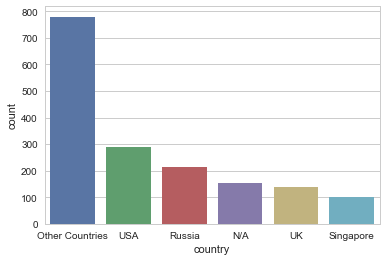

In [26]:
sns.countplot(x="country", data=df2, order = df2['country'].value_counts().index);

USA has the most ICOs, followed by Russia. In fact, the geographical distribution of ICOs is rather dispersed given around 50% of them (over 700 out of 1675) are from countries that have less than 100 ICOs, a truly international investment opportunity!

### 4.3 ICOs by categories

As we have converted the categories into dummy variables, summing them up by columns gives the count of ICOs that belong to each categories (since those belonging to that category were encoded as "1"). This graph shows that over 50% of the ICOs are platforms.

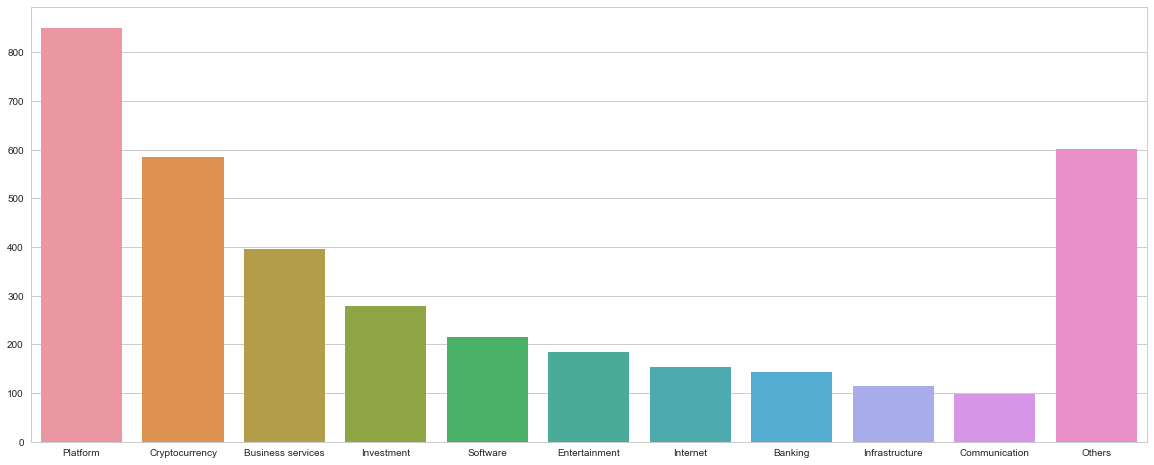

In [27]:
cat_sum = df2[['Platform', 'Cryptocurrency', 'Business services', 'Investment', 'Software', 'Entertainment','Internet', 
    'Banking', 'Infrastructure', 'Communication', 'Others']].sum()

plt.subplots(figsize = (20, 8))
sns.barplot(x=cat_sum.index, y=cat_sum.values);

### 4.3.1 ICO ratings by categories

C:\Users\wmoni\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\wmoni\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  if __name__ == '__main__':
C:\Users\wmoni\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  # Remove the CWD from sys.path while we load stuff.
C:\Users\wmoni\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  # This is added back by InteractiveShellApp.init_path()
C:\Users\wmoni\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: FutureWarning

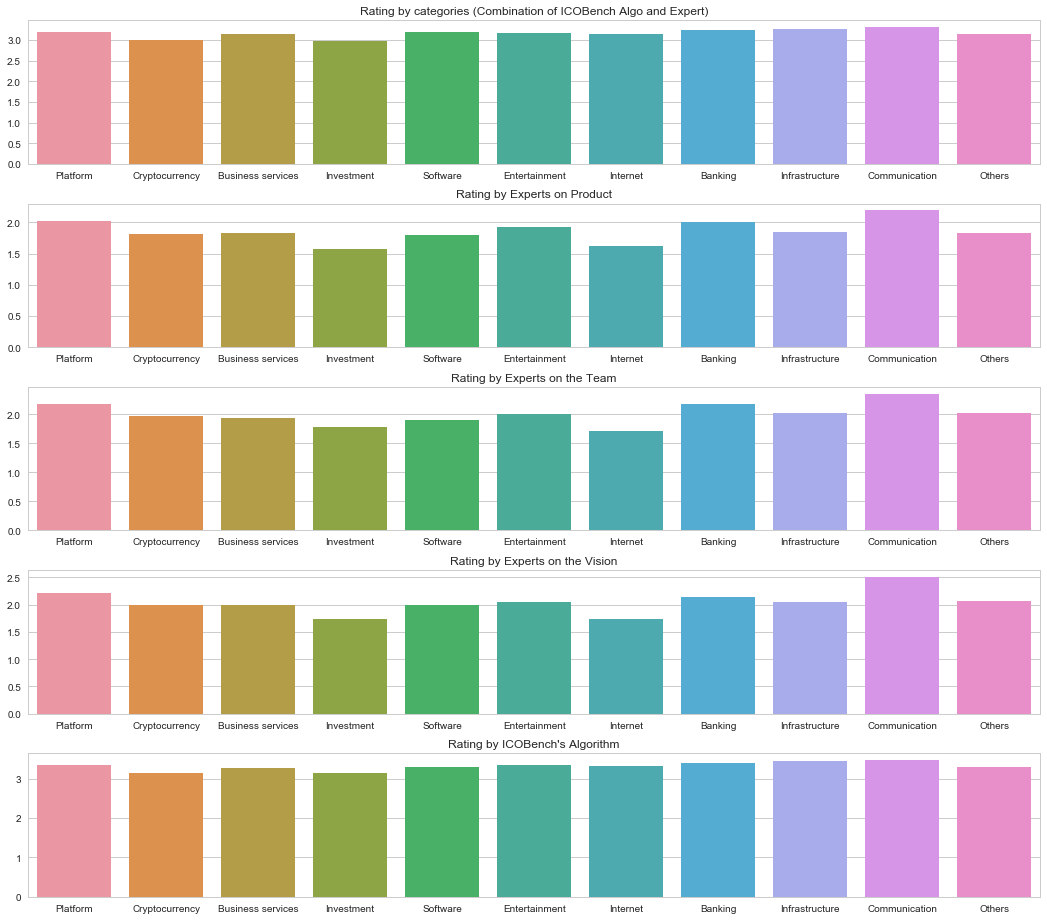

In [28]:
# obtain the mean by categories for each time of ratings
category_rating = []
product_rating = []
profile_rating = []
team_rating = []
vision_rating = []
for cat in cat_list:
    category_rating.append(df2.groupby(cat).mean()[['rating']].get_value(1, 'rating'))
    product_rating.append(df2.groupby(cat).mean()[['ratingProduct']].get_value(1, 'ratingProduct'))
    profile_rating.append(df2.groupby(cat).mean()[['ratingProfile']].get_value(1, 'ratingProfile'))
    team_rating.append(df2.groupby(cat).mean()[['ratingTeam']].get_value(1, 'ratingTeam'))
    vision_rating.append(df2.groupby(cat).mean()[['ratingVision']].get_value(1, 'ratingVision'))


# plot bar charts
fig, ((ax1), (ax2), (ax3), (ax4), (ax5)) = plt.subplots(5, 1, figsize = [15,13])
plt.tight_layout(pad=2, h_pad=None, w_pad=None, rect=None)

sns.barplot(x=cat_list, y=category_rating, ax = ax1).set_title(
    "Rating by categories (Combination of ICOBench Algo and Expert)");
sns.barplot(x=cat_list, y=product_rating, ax = ax2).set_title("Rating by Experts on Product");
sns.barplot(x=cat_list, y=team_rating, ax = ax3).set_title("Rating by Experts on the Team");
sns.barplot(x=cat_list, y=vision_rating, ax = ax4).set_title("Rating by Experts on the Vision");
sns.barplot(x=cat_list, y=profile_rating, ax = ax5).set_title("Rating by ICOBench's Algorithm");

Previously, we noticed that ICOBench's algorithm gave higher rating than the Experts in general. From these charts, we observe that ratings given by ICOBench's algorithm has less variation across categories than those given by Experts. Looking at the "Investment" category, one of the lowest rated categories, we observe that the Experts have given it much lower ratings than other categories on all product, team and vision while ICOBench's algorithm only gave it slightly lower rating than the other categories. 

It would be interesting to find out what is causing this difference. Is it because Experts, or people in general, are more skeptical about certain types of ICO hence gave those a lower rating? Or does ICOBench's algorithm need to be fine-tuned in order to better distinguish different categories when assiging a rating? These charts also show that the combined overall rating is affected more by ICOBench's algorithm. If Experts' ratings are in fact more accurate in predicting an ICOs ROI, higher weights should be assigned to them when calculating the combined overall rating.

### 4.3.2 ICO ROI by categories

Last but not least, let's take a look at the ROIs of ICOs.

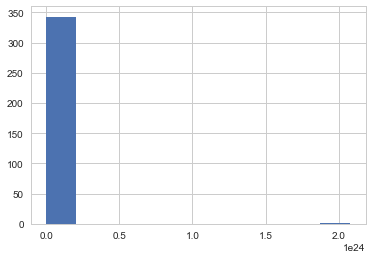

In [29]:
plt.hist(df2['roi_avg_annu'].dropna(), bins = 10)
plt.show()

Whoa, as we observe from the .describe() function, the annualized average ROI is extremely right-skewed. The log function can be used to smooth it out a little bit. Then, we will plot a bar graph to study the ROI of different categories.

C:\Users\wmoni\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


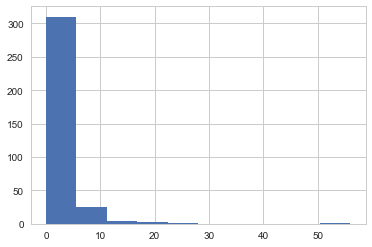

In [30]:
min_roi = df2['roi_avg_annu'].min()
# apply lambda function to convert all roi_avg_annu to positive values for applying log function
df2['log_roi'] = df2['roi_avg_annu'].apply(lambda x: log(x - min_roi + 1))
plt.hist(df2['log_roi'].dropna())
plt.show()

C:\Users\wmoni\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  """


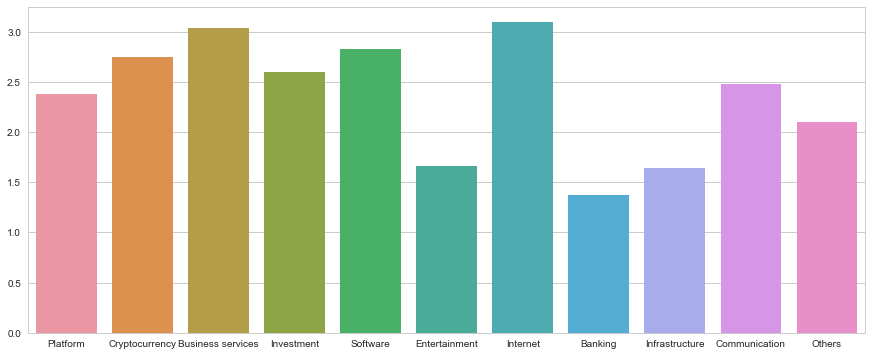

In [31]:
# plotting a bar graph of mean annualized average ROI of different categories
category_mean_roi_log = []

for cat in cat_list:
    category_mean_roi_log.append(df2.groupby(cat).mean()[['log_roi']].get_value(1, 'log_roi'))
plt.subplots(figsize = (15,6))
sns.barplot(x = cat_list, y = category_mean_roi_log);

It's interesting to note that Internet, one of the categories that received lowest ratings from Experts, actually had the highest annualized average ROI. Seems like we can't solely rely on ratings afterall.

### 5. Conclusion
Predicting ICO returns is complicated and requires more understanding of the ICOs business model and the overall ICO landscape and market sentiment. We couldn't really figure out how to distinguish profitable ICOs within the few hour at the Unhackathon using the limited amount of data we had. Here's what we could do if we had more time:
- look into other features available in the data set, for example soft and hard cap of the ICO, amount of funding raised, etc
- obtain time series data of ICOs to study the patterns of price and returns
- scrape data from ICO news websites, the founder's Linkedin profile and the ICO's white paper to learn more about the business model and the team instead of solely relying on ratings